<a href="https://colab.research.google.com/github/Hentonybarboza/MNIST/blob/main/Classificador_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinando um classificador binário

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns

## Importando os dados

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version =1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target'] #Definindo X e y

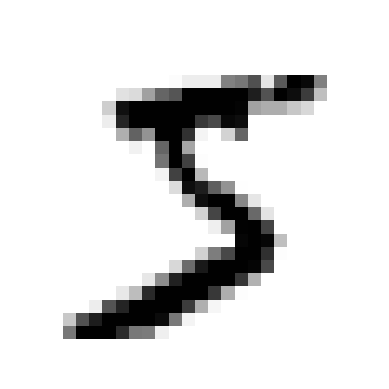

In [40]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [41]:
y= y.astype(np.uint8) #convertendo y para inteiro
y[0]

5

##Separando em conjunto de treino e testa






In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##Treinamento

In [7]:
y_train_5 = (y_train == 5) #selecionando somes o número 5 nos dados de treino e tese
y_test_5 = (y_test == 5)

In [43]:
from sklearn.linear_model import SGDClassifier # O SGD depende da aleatoriedade por isso para resultados
sgd_clf = SGDClassifier(random_state=42)       # Reproduzives é importante definir um random state
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [44]:
sgd_clf.predict([some_digit])

array([ True])

#Cálculo de desempenho

### Validação cruzada

In [45]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv =3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Matriz de confusão


In [47]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3)

In [48]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train_5, y_train_pred)
conf_mat

array([[53892,   687],
       [ 1891,  3530]])

In [49]:
#calcular a precisão
precision = conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1])
precision

0.8370879772350012

In [50]:
from sklearn.metrics import precision_score, recall_score #Cálculo da precisão via biblioteca
precision_score(y_train_5,y_train_pred)


0.8370879772350012

In [51]:
recall_score(y_train_5, y_train_pred) #Cálculo do recall

0.6511713705958311

In [52]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
#O f1 score é uma média harmônica entre o recall e a precisão, a média harmônica
#valoriza mais os menores valores, ou seja, o f1 só será alto se a precisão e o recall forem altos

0.7325171197343847

In [53]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
#Não podems mudar o limiar diretamente mas podemos ver o score que foi dado aos dígitos
#e em seguida podemos fazer predições com o limiar desejado

array([2164.22030239])

In [54]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#Como por padrão o limiar é zero, não teve diferença na predição

array([ True])

In [55]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# Agora que aumentamos o limiar o modelo "perdeu" esse 5, ou seja, diminuímos o
# recall

array([False])

In [56]:
#Agora vamos pegar os scores de todas as predições do modelo
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3,
                             method= "decision_function")


In [57]:
#já temos uma função que plota a curva de precisão e recall
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [58]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


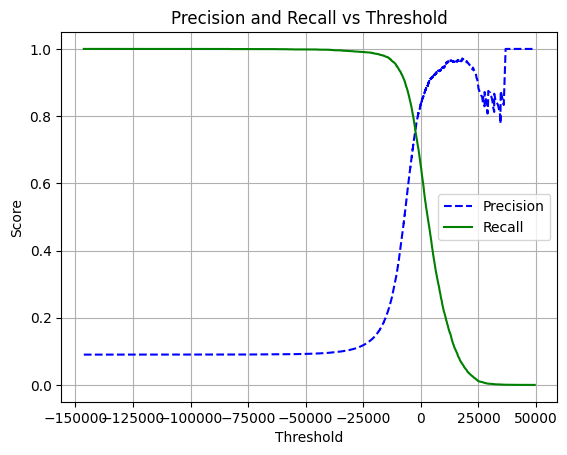

In [59]:
plot_precision_recall_vs_thresholds(precisions, recalls,thresholds)
plt.show()

In [60]:
import matplotlib.pyplot as plt

def plot_precision_vs_recalls(precisions, recalls):
    plt.plot(recalls, precisions, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision vs Recall')
    plt.legend()
    plt.grid()
    plt.show()


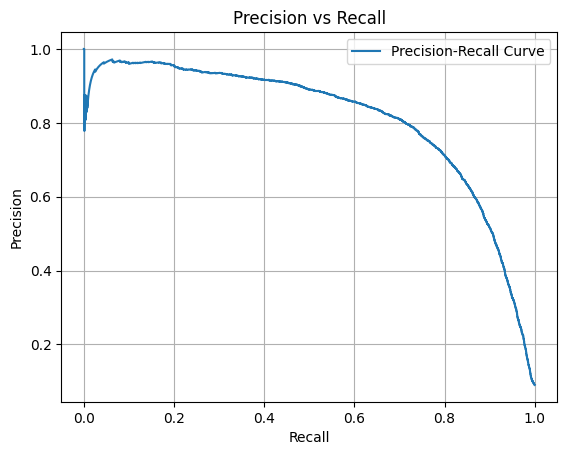

In [61]:
plot_precision_vs_recalls(precisions, recalls)
plt.show()

##CURVA ROC

*Curva de característica de operação*


In [64]:
# A curva roc plota a taxa de verdadeiros postitivos(TPR) em relação a taxa de
# falsos positivos (FPR)
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label =label)
  plt.plot([0,1], [0,1], 'k--')#linha diagonal tracejada
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate (Recall)')
  plt.legend()
  plt.grid()
  plt.show()


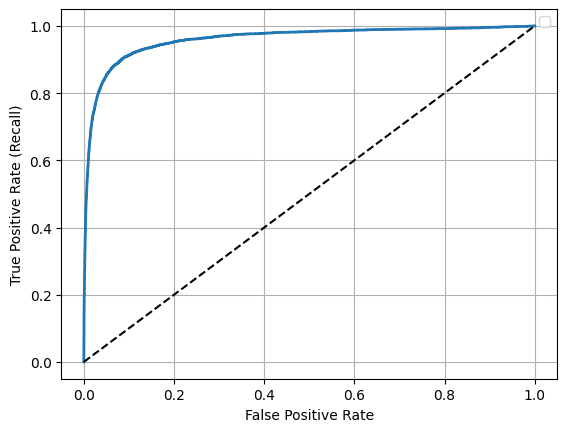

In [67]:
plot_roc_curve(fpr, tpr)
# A linha diagonal representa a curva ROC de um classificador exclusivamente
# aleatório %% Uma forma de comparar modelos é calculando a área sob a curva
# ROC (AUC) Um classificador perfeito terá uma área sob a curva = 1 Um
# classificador aleatório terá uma AUC = 0,5

In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#Random Forest

In [95]:
#Para comparar o método RF com o SGD primeiro preciso pegar os scores do RF
#para isso vou usar o método "predict_proba" que me retorna a probabilidade
# de ser um 5 ou não

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method ="predict_proba")


In [71]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

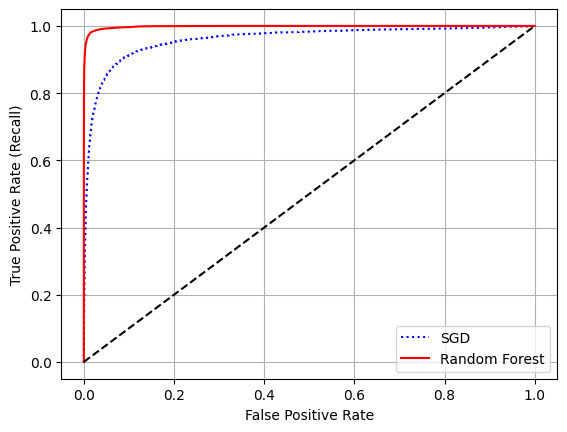

In [88]:
  #PLotando um gráfico para comparar a curva ROC do classificador SGD e do
  #Random Forest

plt.plot(fpr, tpr, "b:", label = "SGD")
plt.plot(fpr_forest, tpr_forest, "r", label = "Random Forest")
plt.plot([0,1], [0,1], 'k--')#linha diagonal tracejada
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid()
plt.show()

## Métricas de desempenho


In [89]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [90]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

In [91]:
precision_score(y_train_5, y_pred_forest)

0.9905083315756169

In [92]:
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

In [93]:
f1_score(y_train_5, y_pred_forest)

0.9242275142688448

In [ ]:
# Podemos notar que o método Random Forest gera um resultado melhor que
#o método SGD

#Classificador Multiclasse

In [96]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)